In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [3]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-10-DATASET.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-11-DATASET.xlsx')
# df = pd.read_excel(
#     "../Data/Original Data/2024_04_26/FINAL CORRECTED DATA 2024-04-26.xlsx"
# )

from pathlib import Path

# input_path = Path("../lc-project-data")
# output_path = Path("../lc-project-data")

# for MP, 
input_path = Path("../Data/Original Data/2024_04_26")
output_path = Path("../Data/DataV2")


df = pd.read_excel(input_path / "FINAL-CORRECTED-DATA-2024-04-26.xlsx")

In [4]:
df.shape

(5664, 692)

In [5]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = df.copy()
preserved_df.shape

(5664, 692)

In [6]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [7]:
df = preserved_df

In [8]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 692 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](7), float64(655), int64(10), object(20)
memory usage: 29.9+ MB


In [9]:
# A list of columns to drop
to_drop = []

In [10]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [11]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                149
MALE                   64
Male                    4
TRANSGENDER FEMALE      1
Name: count, dtype: int64
Nulls = 5446


In [12]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# info on the adjunctive columns
print(preserved_df[adj_cols].info())
print(preserved_df[adj_cols].describe())
print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adjunctive___1   3367 non-null   float64
 1   adjunctive___2   3363 non-null   float64
 2   adjunctive___3   3254 non-null   float64
 3   adjunctive___4   3254 non-null   float64
 4   adjunctive___5   3254 non-null   float64
 5   adjunctive___6   3254 non-null   float64
 6   adjunctive___7   3254 non-null   float64
 7   adjunctive___8   3254 non-null   float64
 8   adjunctive___9   3254 non-null   float64
 9   adjunctive___10  3254 non-null   float64
dtypes: float64(10)
memory usage: 442.6 KB
None
       adjunctive___1  adjunctive___2  adjunctive___3  adjunctive___4  \
count     3367.000000     3363.000000          3254.0          3254.0   
mean         0.032076        0.000297             0.0             0.0   
std          0.176228        0.017244             0.0             0.0   
m

In [13]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 33 columns


['other_hhx4',
 'other_hhx5',
 'other_hhx6',
 'other_hhx7',
 'other_hhx8',
 'other_hhx9',
 'other_hhx10',
 'medication8',
 'medication9',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [14]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(5664, 659)

In [15]:
# get all column names
df_columns = df.columns

## TODO

In [16]:
# TODO: one-hot encode mode of diag


df["mode_of_diag"].value_counts(dropna=False)

mode_of_diag
1.0    3481
NaN    1108
2.0     863
0.0     184
5.0      20
3.0       7
4.0       1
Name: count, dtype: int64

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [17]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3367
LC_POS    2215
HC          82
Name: count, dtype: int64

In [18]:
pd.crosstab(df.LC_STATUS, df.dag.map(site_name_dict))

dag,LDN,LUS,MTL,RIO,SAN
LC_STATUS,,,,,
HC,32,38,0,9,3
LC_NEG,177,994,1997,128,71
LC_POS,110,272,916,651,266


In [19]:
pd.crosstab(df.LC_STATUS, df.dag.map(site_name_dict), normalize='columns').round(2)

dag,LDN,LUS,MTL,RIO,SAN
LC_STATUS,,,,,
HC,0.10,0.03,0.00,0.01,0.01
LC_NEG,0.55,0.76,0.69,0.16,0.21
LC_POS,0.34,0.21,0.31,0.83,0.78


## DEMOGRAPHICS
- apr 27 - LUS increase in missing data for HCP and MICRO w apr 26 data

In [20]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5664, 5)

In [21]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     5614 non-null   float64
 1   age     5620 non-null   float64
 2   hcp     3290 non-null   float64
 3   micro   3163 non-null   float64
 4   dag     5664 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 221.4 KB


In [22]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,1,49
age,1,0,0,1,42
hcp,80,148,224,734,1188
micro,90,158,227,768,1258
dag,0,0,0,0,0


In [23]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/tmp/ipykernel_278514/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(5664, 3)

### PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [24]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,7,0
2,0,0,75
3,38,0,0
4,0,0,241
5,0,328,0
6,0,0,1690
7,0,1886,0
8,0,0,83
10,0,1146,0


In [25]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'dag', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

dag,1,2,3,4,5
participant_type,,,,,
1,2,0,0,0,5
2,33,0,39,0,3
3,0,0,0,0,38
4,0,241,0,0,0
5,0,328,0,0,0
6,77,592,227,651,143
7,175,523,71,128,989
8,0,83,0,0,0
10,0,1146,0,0,0


### SITES

- summary of LC status by site
- not a feature set
- information only

In [26]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,32,177,110
MTL,0,1997,916
SAN,3,71,266
RIO,9,128,651
LUS,38,994,272


In [27]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    2913
LUS    1304
RIO     788
SAN     340
LDN     319
Name: count, dtype: int64

In [28]:
# get the range of indices for each site
site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

/tmp/ipykernel_278514/1871863930.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore


dag
MTL       (0, 2912)
RIO    (2913, 3700)
LUS    (3701, 5624)
SAN    (4969, 5663)
LDN    (5270, 5590)
dtype: object

## SUBSTANCE USE

In [29]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]

# fill na with 0
# substance_features = substance_features.fillna(0)

In [30]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      0.0      NaN      0.0      0.0
 1      0.0      0.0      NaN      0.0      0.0
 2      0.0      0.0      NaN      0.0      0.0
 3      1.0      0.0      NaN      0.0      0.0
 4      0.0      0.0      NaN      0.0      0.0,
 (5664, 5))

In [31]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1258
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1258
substances___5,81,0,0,121,0


In [32]:
substance_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SUBST-1  5583 non-null   float64
 1   SUBST-2  4204 non-null   float64
 2   SUBST-3  2549 non-null   float64
 3   SUBST-4  4204 non-null   float64
 4   SUBST-5  5462 non-null   float64
dtypes: float64(5)
memory usage: 221.4 KB


In [33]:
### CONCLUSION: 
# - do not use the SUBSTANCES columns, as there is significant missing data

## MEDICATIONS
 - one hot encode

In [34]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1',
 'medication2',
 'medication3',
 'medication4',
 'medication5',
 'medication6',
 'medication7',
 'medication10']

In [35]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [36]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      29 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    21 columns
(5664, 29)


In [37]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

In [38]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
medication_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MED-Analgesics                         5664 non-null   int64
 1   MED-Anesthetics                        5664 non-null   int64
 2   MED-Antibacterials                     5664 non-null   int64
 3   MED-Anticonvulsants                    5664 non-null   int64
 4   MED-Antidepressants                    5664 non-null   int64
 5   MED-Antifungals                        5664 non-null   int64
 6   MED-Antimigraine-agents                5664 non-null   int64
 7   MED-Antiparasitics                     5664 non-null   int64
 8   MED-Antiparkinson-agents               5664 non-null   int64
 9   MED-Antipsychotics                     5664 non-null   int64
 10  MED-Antispasticity-agents              5664 non-null   int64
 11  MED-Antivirals                

## HEALTH HISTORY

### HHX - Patient History

In [40]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [41]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [42]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5662,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,26,655,97,43,497
past_hhx___2,1,17,4,0,0
past_hhx___3,17,193,45,0,73
past_hhx___4,22,344,86,22,183
past_hhx___5,9,232,19,2,7
past_hhx___6,7,141,7,0,8
past_hhx___7,6,105,12,0,8
past_hhx___8,5,136,15,0,6
past_hhx___9,1,15,0,0,0
past_hhx___10,1,75,9,1,1


In [44]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,60,0,0,0,0
past_hhx___2,81,0,0,121,1258
past_hhx___3,74,0,0,121,0
past_hhx___4,66,0,0,0,0
past_hhx___5,76,0,0,0,0
past_hhx___6,80,0,0,121,0
past_hhx___7,76,0,0,121,0
past_hhx___8,81,0,0,0,0
past_hhx___9,81,0,0,0,1258
past_hhx___10,81,0,0,0,0


### HHX-OTHER - One-hot encode `other_hhx`


In [45]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx11', 'other_hhx2', 'other_hhx3']

In [46]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index

# NOTE THAT WE ARE FILLING NANS WITH ZERO HERE
# ASSUMPTION: if it's not reported, it's not present
a = df[OTHER_HHX_TEMP].fillna(0).values

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [47]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-DVT,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,...,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-fatigue,HHX-OTHER-surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# use get_dummies to one0hot encode the other_hhx column
# this assigns nans a value of zero by default.
# turning on the dummy_na flag will create a separate column for nans
# we would want to drop that column as it is not useful
# QUESTION: when taking a patient's history, is it safe to assume that they were asked "do you have any other health issues?" and if there is no response, the answer is "no"?

# this is only useful for a single column
# there are 4 cols of other_hhx, so we use the same method as for meds above.

# other_hhx_features = pd.get_dummies(
#                                     # df["other_hhx"], 
#                                     # columns = ["other_hhx"], 
#                                     df[OTHER_HHX_TEMP], 
#                                     columns = OTHER_HHX_TEMP, 
#                                     prefix = "OTHER-HHX", 
#                                     prefix_sep = "-", 
#                                     dtype = int, 
#                                     # dummy_na = True
#                                     )

# print(other_hhx_features.shape)

In [49]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-DVT,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0


### Concatenate health history

In [50]:
# concatenate the health hx features with the other health hx features

# sort hhx_df columns
hhx_df = hhx_df.reindex(sorted(hhx_df.columns), axis=1) # type: ignore

# sort other_hhx_features columns
other_hhx_features = other_hhx_features.reindex(sorted(other_hhx_features.columns), axis=1)

# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [51]:
#==============================================================================
# 2024-04-28
# In keeping with issues #1, #4, etc., - assume that if it's not reported, it wasn't volunteered by px, nor was it identified by physician/interviewer
# therefore, fill nans with zero

## MP - Created issue #5 to confirm
#==============================================================================
hx_features_all = hx_features_all.fillna(0) 

In [52]:
# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
# print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


Text(0.5, 1.0, 'Health History Features')

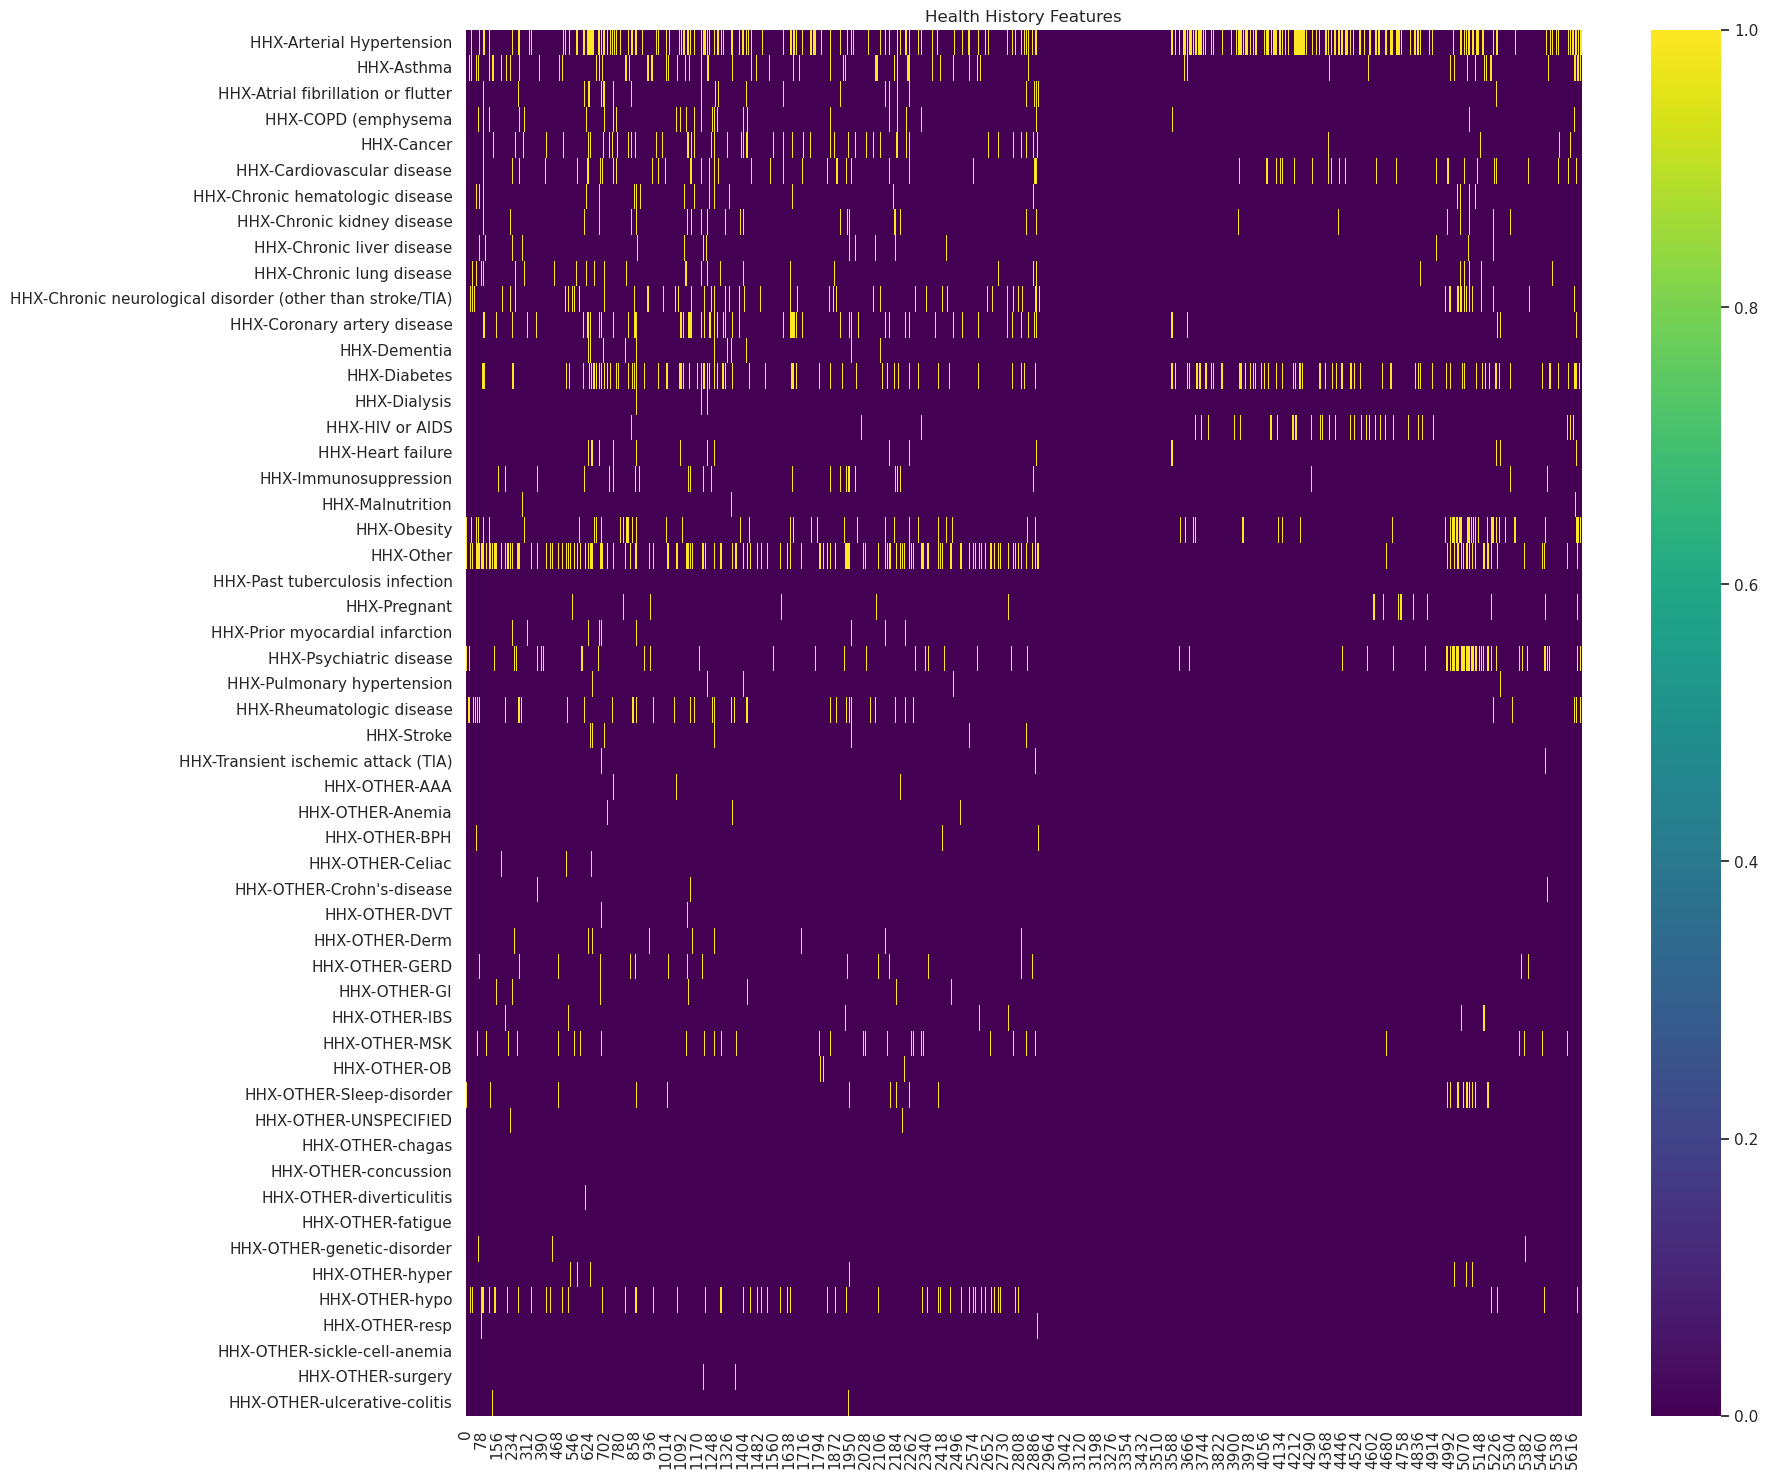

In [53]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SURVEYS

In [54]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col if "complete" not in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
# it's scooped up in the above line
# GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
# these columns were intermedaries and are not useful in the analysis, so we don't need these
# PHX_COMPLETE    = ["phx_complete"]
# PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
# PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

# the set of survey columns
SURVEYS = GAD + PROMIS + PHQ

In [55]:
survey_features = df[SURVEYS]
survey_features.shape

(5664, 47)

<Axes: >

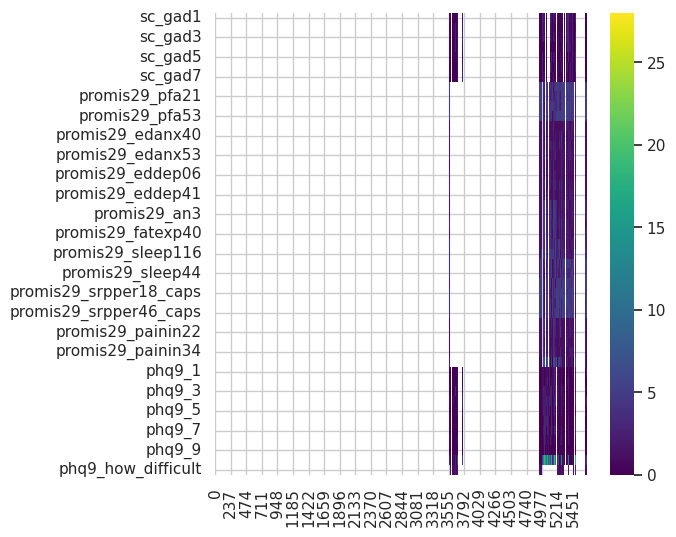

In [56]:
# plot it as a heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(survey_features.T, cbar=True, ax = ax, cmap = 'viridis')

In [57]:
### CONCLUSION:
# - survey featureas are mostly missing, so we will not use them in the larger dataset


## SYMPTOMS

In [58]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# ANSWER: per MP's email of 2024-04-28, we should assume that no response is equivalent to a "no" and encode as zero - #NOTE Issue #1

symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1) # type: ignore

symptom_features.shape

(5664, 56)

In [59]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
# df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


<Axes: >

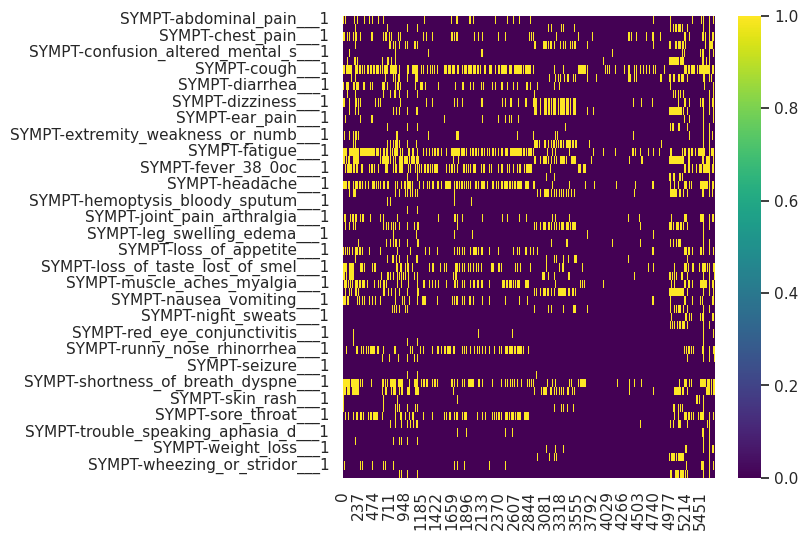

In [60]:
fig, ax = plt.subplots(figsize=(6,6))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [61]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

### IMG - Imaging

- assume that imaging (ct*, cx*, echo*, ekg*) were only ordered for patients that had symptoms or otherwised needed imaging
- for each modality, if the patient has a 1, the imaging was indicated, otherwise it was not indicated and encode a zero


In [62]:
#==============================================================================
# 2024-04-28: this is now DEPRECATED
#==============================================================================

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]

# # count items that start with ct
# print(df.filter(regex='^ct', axis = 1).count())
# df["ctaresult"].value_counts(), df["cttresult"].value_counts(), df["cthresult"].value_counts()
# CTA, CTT, CTH - most of the results are 2 - no report
# CONCLUSION: recommend dropping these - there are very few discriminant results
# # count items that start with cx
# print(df.filter(regex='^cx', axis = 1).count())
# # count cxr code values
# df["cxrresult"].value_counts(), df["cxrcode"].value_counts()

# # most are no-result. Of the 39 that are a positive finding, what are the results?


# # 33 fluid, etc
# # 3 fibrosis
# # 2 nodules, cysts
# # 2 congestive heart disease etc
# CONCLUSION: recommend dropping these too - very small numbers
# # # now echo
# # # count items that start with ct
# # print(df.filter(regex='^echo', axis = 1).count())

# # df["echoresult"].value_counts()
# # # mostly no reports, 7 positive findings
# # finally, ekg
# print(df.filter(regex='^ekg', axis = 1).count())

# print(df["ekgresult"].value_counts())

# print(df["ekgcode"].value_counts())

# # ekgcode results indicate 
# # 10 sinus bradycardia
# # 2 atrioventricular block
# # 1 each of supraventricular, sinus tachy, infarction

# # CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# # numbers are very very small
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [63]:

#==============================================================================
# 2024-04-28: issue #4 - assume imaging ordered for patients who need it for 
# some reason or another
#==============================================================================
# concept: either imaging is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that imaging was not indicated

IMAGING_INVESTIGATIONS = ["cta", "cth", "ctt", "cxr", "echocardiogram", "ekg", "imaging", "spirometry", ]

# pretty sure spirometry isn't an imaging modality, but it was either ordered for a px, or not
print(df[IMAGING_INVESTIGATIONS].info())

# if it wasn't reported, it we assume it wasn't ordered
# fill missing values with zero
imaging_features = df[IMAGING_INVESTIGATIONS].fillna(0)

# rename the columns by prepending IMG
imaging_features.columns = [f"IMG-{col}" for col in imaging_features.columns]

# summarize
imaging_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cta             72 non-null     float64
 1   cth             73 non-null     float64
 2   ctt             292 non-null    float64
 3   cxr             327 non-null    float64
 4   echocardiogram  236 non-null    float64
 5   ekg             252 non-null    float64
 6   imaging         51 non-null     float64
 7   spirometry      2092 non-null   float64
dtypes: float64(8)
memory usage: 354.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMG-cta             5664 non-null   float64
 1   IMG-cth             5664 non-null   float64
 2   IMG-ctt             5664 non-null   float64
 3   IMG-cxr             5664 non-null   float

### LAB  - Lab Tests

In [109]:
# count all values in features
df[CLINICAL_TESTS].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1375 non-null   float64
 1   alt               1723 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1062 non-null   float64
 4   basophil          594 non-null    float64
 5   basophil_count    835 non-null    float64
 6   bilirubin         1453 non-null   float64
 7   bilirubin_direct  696 non-null    float64
 8   cpk               151 non-null    float64
 9   creatinine        1483 non-null   float64
 10  crp               1590 non-null   float64
 11  eosinophil        548 non-null    float64
 12  eosinophil_count  836 non-null    float64
 13  ferritin          898 non-null    float64
 14  fibrinogen        758 non-null    float64
 15  glucose           1074 non-null   float64
 16  haemoglobin       1965 non-null   float64


In [123]:
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "lung_function", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1375 non-null   float64
 1   alt               1723 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1062 non-null   float64
 4   basophil          594 non-null    float64
 5   basophil_count    835 non-null    float64
 6   bilirubin         1453 non-null   float64
 7   bilirubin_direct  696 non-null    float64
 8   cpk               151 non-null    float64
 9   creatinine        1483 non-null   float64
 10  crp               1590 non-null   float64
 11  eosinophil        548 non-null    float64
 12  eosinophil_count  836 non-null    float64
 13  ferritin          898 non-null    float64
 14  fibrinogen        758 non-null    float64
 15  glucose           1074 non-null   float64
 16  haemoglobin       1965 non-null   float64


Text(0.5, 1.0, 'Clinical Tests')

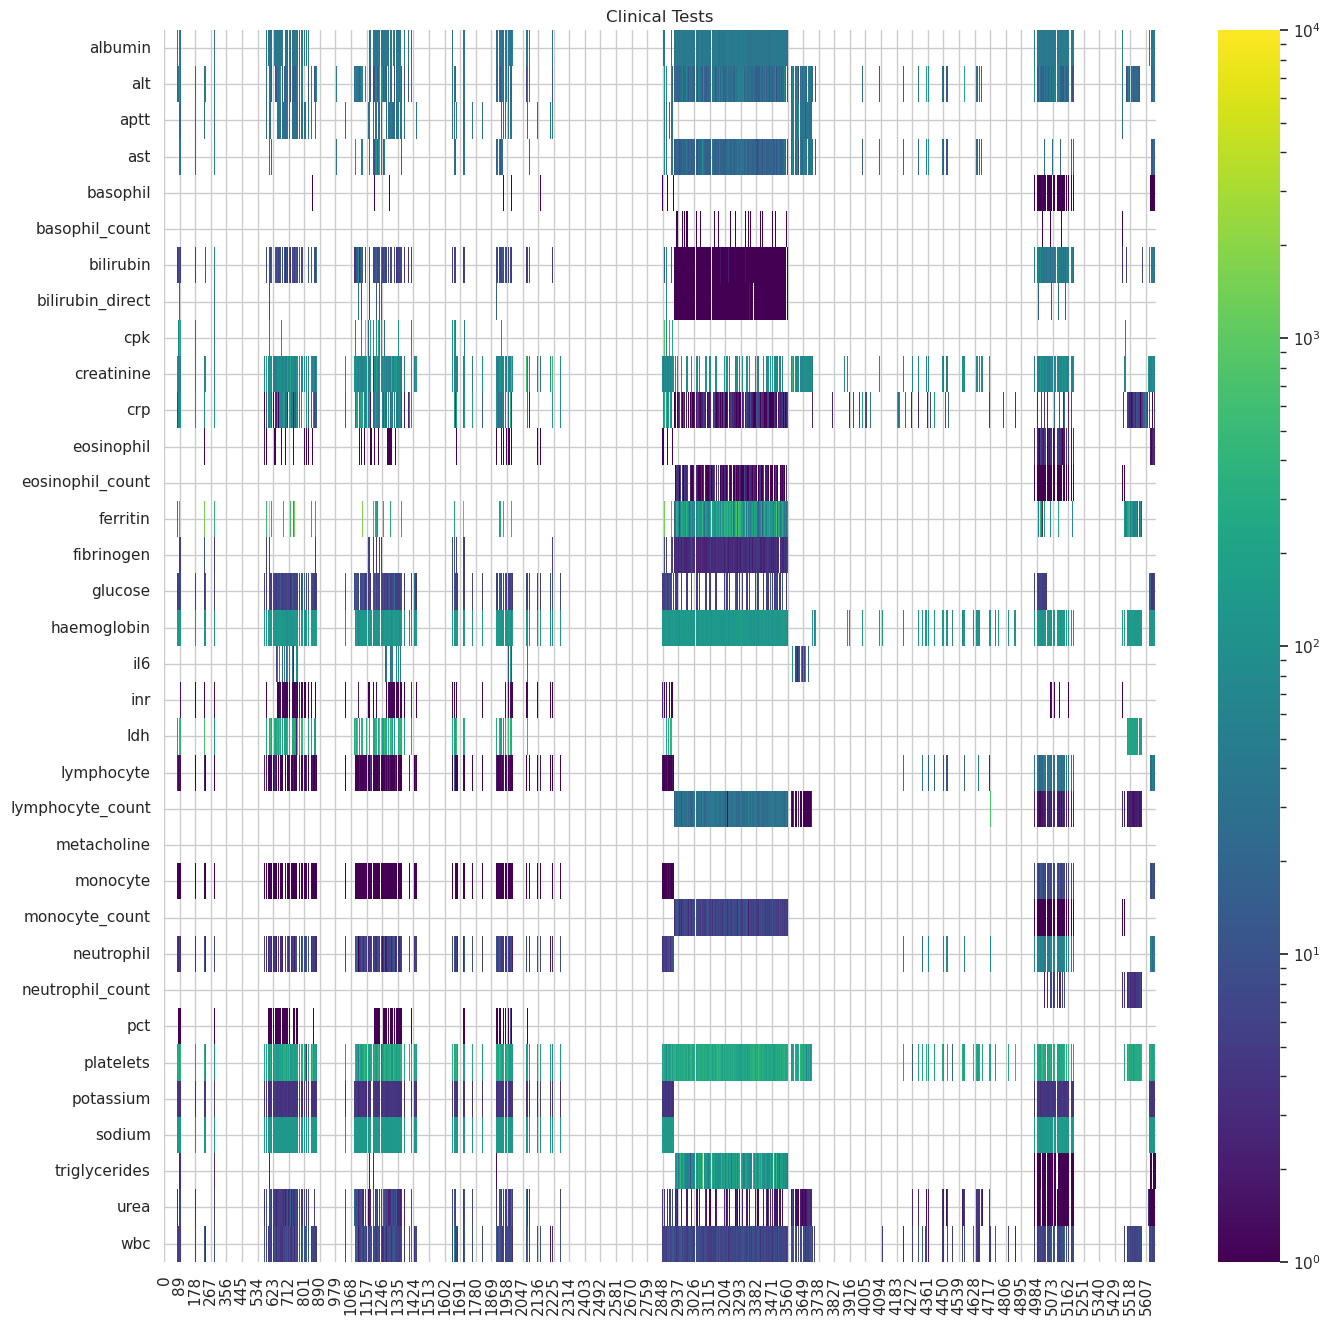

In [124]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
plt.title("Clinical Tests")

In [125]:
df.dag.value_counts()

dag
2    2913
5    1304
4     788
3     340
1     319
Name: count, dtype: int64

### Treat Outliers

In [126]:
# treat outliers before imputing data
# if we even impute the data

from project_modules.data_prep import treat_outliers
labs_without_outliers = treat_outliers(df[CLINICAL_TESTS], z_threshold = 4, method = "median")

>>> Using z-threshold = 4.00 to identify outliers.
>>> There are 208 outliers in the data for abs(z) ≥ 4.00.
>>> Outliers are 3.67% of the total data.
>>> Replacing outliers with median.
albumin              40.00
alt                  27.00
aptt                 31.55
ast                  23.00
basophil              0.00
basophil_count        0.00
bilirubin             5.00
bilirubin_direct      0.10
cpk                 107.00
creatinine           78.00
crp                   6.95
eosinophil            0.10
eosinophil_count      1.00
ferritin            156.00
fibrinogen            3.40
glucose               6.10
haemoglobin         134.00
il6                  35.10
inr                   1.10
ldh                 298.00
lymphocyte            1.20
lymphocyte_count     24.00
metacholine           0.00
monocyte              0.60
monocyte_count        6.00
neutrophil            6.50
neutrophil_count      4.21
pct                   0.13
platelets           243.00
potassium             4.10
sod

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [127]:
labs_without_outliers.describe()

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,monocyte_count,neutrophil,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc
count,1375.000000,1723.000000,580.000000,1062.00000,594.000000,835.000000,1453.000000,696.000000,151.000000,1483.000000,...,836.000000,1027.000000,154.000000,363.000000,2032.000000,1051.000000,1052.000000,857.000000,1272.000000,2047.000000
mean,39.169745,34.926837,31.978948,29.66629,0.139899,0.100240,11.367626,0.914943,289.178808,85.289180,...,5.449043,18.923439,4.325260,0.278595,250.518898,4.084110,137.673954,103.366978,4.289087,7.398935
std,4.651187,24.983795,7.653760,21.84581,0.203860,0.295611,17.971952,3.297386,552.398106,42.477039,...,3.329086,23.422936,1.556468,0.501534,88.961987,0.535132,4.071105,99.027451,3.838247,3.055987
min,17.000000,5.000000,1.400000,1.60000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,...,0.000000,0.600000,1.400000,0.020000,1.000000,2.200000,121.000000,0.100000,0.300000,1.000000
25%,37.000000,19.000000,27.275000,17.00000,0.000000,0.000000,0.500000,0.100000,52.500000,62.000000,...,3.000000,4.100000,3.192500,0.080000,190.000000,3.800000,136.000000,1.700000,1.610000,5.400000
50%,40.000000,27.000000,31.525000,23.00000,0.000000,0.000000,5.000000,0.100000,107.000000,78.000000,...,6.000000,6.500000,4.165000,0.130000,243.000000,4.100000,138.000000,92.000000,3.300000,6.900000
75%,42.000000,41.000000,35.200000,33.00000,0.200000,0.000000,12.000000,0.100000,268.000000,94.794000,...,8.000000,19.000000,5.100000,0.240000,302.000000,4.400000,140.000000,149.000000,5.625000,8.800000
max,51.000000,179.400000,79.900000,161.00000,0.900000,1.000000,114.920000,23.200000,4188.000000,441.000000,...,18.000000,86.900000,9.850000,3.800000,634.000000,6.500000,153.000000,568.000000,22.800000,22.500000


### Consider Imputation by Site 
Summary -- Too many missing per site -- avoid imputation - MP Apr 28

In [128]:
print('Percent Missing of Lab By Site')
(df.groupby("dag")[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(
    index=site_name_dict
).T / df.dag.value_counts().rename(index=site_name_dict)).round(2)

Percent Missing of Lab By Site


dag,LDN,LUS,MTL,RIO,SAN
albumin,0.99,1.00,0.82,0.20,0.34
alt,0.77,0.94,0.79,0.06,0.35
aptt,1.00,1.00,0.84,0.87,1.00
ast,1.00,0.94,0.94,0.06,0.82
basophil,1.00,1.00,0.87,1.00,0.40
basophil_count,0.94,1.00,1.00,0.19,0.48
bilirubin,0.98,1.00,0.80,0.20,0.34
bilirubin_direct,1.00,1.00,0.98,0.20,0.95
cpk,0.98,1.00,0.95,1.00,1.00
creatinine,0.97,0.91,0.72,0.60,0.32


Percent Missing of Lab By Site


Text(0.5, 1.0, 'Percent of Lab Missing By Site')

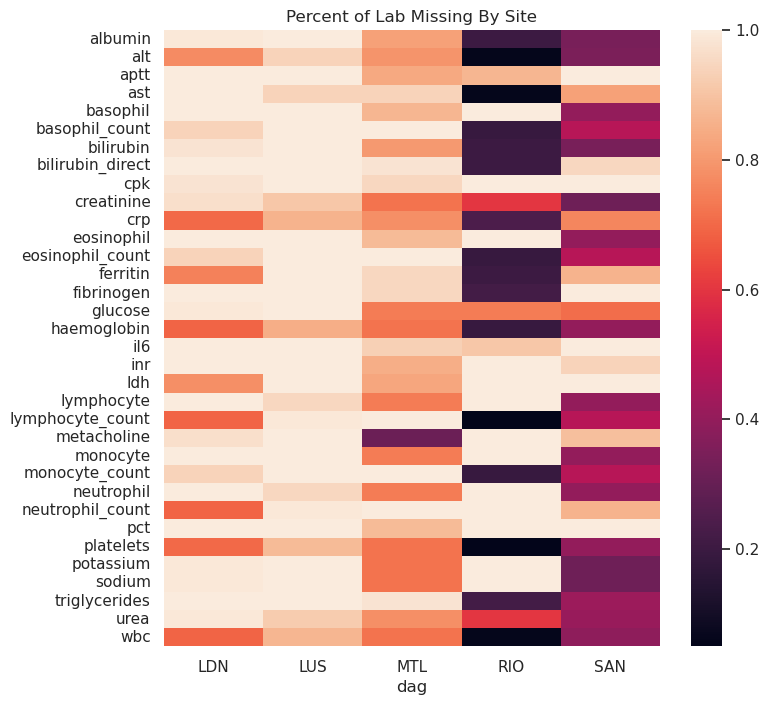

In [129]:
print('Percent Missing of Lab By Site')
sns.heatmap(
    (
        df.groupby("dag")[CLINICAL_TESTS]
        .apply(lambda x: x.isnull().sum())
        .rename(index=site_name_dict)
        .T
        / df.dag.value_counts().rename(index=site_name_dict)
    ).round(2)
)
plt.title("Percent of Lab Missing By Site")

In [127]:
#shows that there are no real good labs that have a decent number across all sites.. we just wouldnt beable to control for site differences between labs if imputed
print('Maximum percent missing per lab across all site.')
((df.groupby("dag")[CLINICAL_TESTS].apply(
    lambda x: x.isnull().sum()
).T / df.dag.value_counts()).round(2)).T.max().sort_values()

Maximum percent missing per lab across all site.


haemoglobin         0.85
crp                 0.86
wbc                 0.87
platelets           0.88
alt                 0.94
creatinine          0.97
urea                0.99
ast                 1.00
triglycerides       1.00
sodium              1.00
potassium           1.00
pct                 1.00
neutrophil_count    1.00
neutrophil          1.00
monocyte_count      1.00
monocyte            1.00
metacholine         1.00
lymphocyte_count    1.00
lymphocyte          1.00
inr                 1.00
aptt                1.00
il6                 1.00
glucose             1.00
fibrinogen          1.00
ferritin            1.00
eosinophil_count    1.00
eosinophil          1.00
cpk                 1.00
bilirubin_direct    1.00
bilirubin           1.00
basophil_count      1.00
basophil            1.00
ldh                 1.00
albumin             1.00
dtype: float64

In [100]:
# how many nulls per site?
print("Missing CLINICAL values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing CLINICAL values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",117,158,"1,304"
alt,246,"2,303",118,48,"1,226"
aptt,318,"2,436",340,686,"1,304"
ast,319,"2,728",279,48,"1,228"
basophil,319,"2,523",136,788,"1,304"
basophil_count,300,"2,913",162,150,"1,304"
bilirubin,313,"2,323",116,155,"1,304"
bilirubin_direct,319,"2,867",324,154,"1,304"
cpk,313,"2,768",340,788,"1,304"
creatinine,308,"2,102",110,474,"1,187"


In [101]:
# how many nulls by LC_STATUS?
print("Missing CLINICAL values by LC_STATUS:")
df.groupby('LC_STATUS')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).T.map(lambda x: f"{x:,}") # type: ignore

Missing CLINICAL values by LC_STATUS:


LC_STATUS,HC,LC_NEG,LC_POS
albumin,82,"3,084","1,123"
alt,82,"2,870",989
aptt,82,"3,011","1,991"
ast,82,"3,086","1,434"
basophil,82,"3,166","1,822"
basophil_count,82,"3,365","1,382"
bilirubin,82,"3,056","1,073"
bilirubin_direct,82,"3,334","1,552"
cpk,82,"3,283","2,148"
creatinine,82,"2,739","1,360"


### consider imputing the labs data, by sex and by site

<Axes: xlabel='dag'>

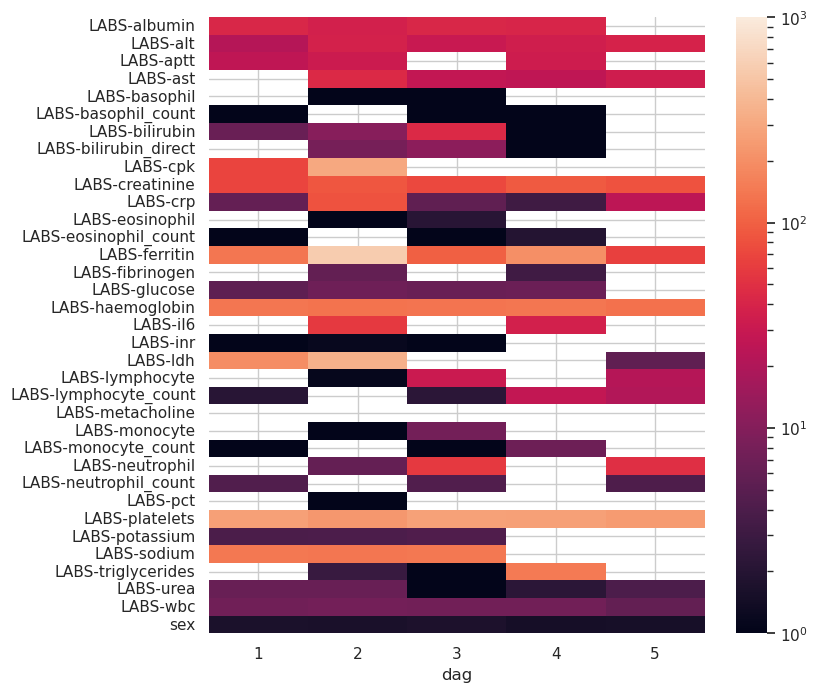

In [134]:
# given the labs_without_outliers, we need to add sex and site back in
# we also need to add in the LC_STATUS column

t1 = pd.concat([labs_without_outliers, df[["sex", "dag"]]
                ], axis = 1)

norm = mc.LogNorm(vmin=1, vmax=1_000)

# get means by site
sns.heatmap(t1.groupby("dag").mean().T, norm = norm)



In [510]:
# 2024-04-28: this is now DEPRECATED
# originally the haemoglobin values were measured in different unit systems

# # let's have a look
# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = "dag", y = "haemoglobin", ax = ax)

# # simple unit check
# # hameoglobin is specified in diction as [g L^-1]
# # normal range is 130-180 [g L^-1]
# # LUSAKA values are in the 10s, so must be in [g dL^-1]
# # convert to [g L^-1]

# # find the LUSAKA values
# lusaka_haemoglobin = t1.query('dag == 5')["haemoglobin"]

# # convert to [g L^-1]
# lusaka_haemoglobin = lusaka_haemoglobin * 10

# lusaka_haemoglobin.describe()

# # now we can see that the values are in the normal range

# # replace the values in the dataframe
# t1.loc[t1["dag"] == 5, "haemoglobin"] = lusaka_haemoglobin

# # haemoglobin values look odd in a table DT made
# # let's have a look

# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = t1["dag"].map(site_name_dict), y = "haemoglobin", ax = ax)

In [147]:
t1.groupby(["dag", "sex"]).count()[
    [
        "LABS-alt",
        "LABS-creatinine",
        "LABS-crp",
        "LABS-haemoglobin",
        "LABS-platelets",
        "LABS-urea",
        "LABS-wbc",
    ]
]

LABS-alt  LABS-creatinine  LABS-crp  LABS-haemoglobin  \
dag sex                                                          
1   1.0        31                2        41                40   
    2.0        42                9        55                60   
2   1.0       354              460       367               465   
    2.0       256              351       263               357   
3   1.0        70               71        16                54   
    2.0       152              159        64               150   
4   1.0       373              163       286               306   
    2.0       366              150       313               331   
5   1.0        35               51        82                81   
    2.0        41               64       101               117   

         LABS-platelets  LABS-urea  LABS-wbc  
dag sex                                       
1   1.0              39          1        39  
    2.0              58          2        60  
2   1.0             465        362       467  
    2.0             360        290       362  
3   1.0              54         63        55  
    2.0             150        139       151  
4   1.0             375        164       372  
    2.0             370        149       370  
5   1.0              61         44        70  
    2.0              96         55        97

In [148]:
pd.crosstab(t1.dag,t1.sex)

sex,1.0,2.0
dag,,
1,114,205
2,1182,1731
3,100,240
4,396,391
5,592,663


In [ ]:
t1.groupby(["dag", "sex"]).count()[
    [
        "LABS-alt",
        "LABS-creatinine",
        "LABS-crp",
        "LABS-haemoglobin",
        "LABS-platelets",
        "LABS-urea",
        "LABS-wbc",
    ]
]

LABS-alt  LABS-creatinine  LABS-crp  LABS-haemoglobin  \
dag sex                                                          
1   1.0        31                2        41                40   
    2.0        42                9        55                60   
2   1.0       354              460       367               465   
    2.0       256              351       263               357   
3   1.0        70               71        16                54   
    2.0       152              159        64               150   
4   1.0       373              163       286               306   
    2.0       366              150       313               331   
5   1.0        35               51        82                81   
    2.0        41               64       101               117   

         LABS-platelets  LABS-urea  LABS-wbc  
dag sex                                       
1   1.0              39          1        39  
    2.0              58          2        60  
2   1.0             465        362       467  
    2.0             360        290       362  
3   1.0              54         63        55  
    2.0             150        139       151  
4   1.0             375        164       372  
    2.0             370        149       370  
5   1.0              61         44        70  
    2.0              96         55        97

In [135]:
t1.groupby(["sex", "dag"]).transform(lambda x: x.fillna(x.median()))

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/num

,LABS-albumin,LABS-alt,LABS-aptt,LABS-ast,LABS-basophil,LABS-basophil_count,LABS-bilirubin,LABS-bilirubin_direct,LABS-cpk,LABS-creatinine,...,LABS-monocyte_count,LABS-neutrophil,LABS-neutrophil_count,LABS-pct,LABS-platelets,LABS-potassium,LABS-sodium,LABS-triglycerides,LABS-urea,LABS-wbc
0,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
1,36.0,32.0,31.55,39.0,0.0,NaN,9.00,8.80,153.0,85.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,5.8000,7.20
2,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
3,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
4,36.0,32.0,31.55,39.0,0.0,NaN,9.00,8.80,153.0,85.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,5.8000,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,44.0,30.0,NaN,20.0,0.4,0.0,44.20,17.70,NaN,96.356,...,0.6,59.85,4.505,NaN,233.0,4.6,142.0,0.40,0.6660,6.90
5660,38.0,17.0,NaN,13.0,0.2,0.0,35.40,8.90,NaN,63.648,...,0.5,74.00,4.065,NaN,405.0,4.5,138.0,0.40,0.6105,13.88
5661,42.0,30.5,NaN,27.0,0.4,0.0,44.20,17.70,NaN,82.200,...,0.6,59.85,4.505,NaN,233.0,4.2,140.0,0.30,0.8000,6.90
5662,43.0,24.0,NaN,24.0,0.4,0.0,70.72,17.70,NaN,146.744,...,0.6,59.85,4.505,NaN,233.0,4.9,138.0,0.40,2.3310,6.90


In [511]:
                                 
# group by sex and dag
t2 = t1.groupby(["sex", "dag"]).transform(lambda x: x.fillna(x.median()))


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-

In [512]:
t2

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,monocyte_count,neutrophil,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc
0,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
1,36.0,32.0,31.55,39.0,0.0,NaN,9.00,8.80,153.0,85.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,5.8000,7.20
2,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
3,37.0,23.0,30.70,33.5,0.0,NaN,7.00,3.75,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.3000,6.60
4,36.0,32.0,31.55,39.0,0.0,NaN,9.00,8.80,153.0,85.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,5.8000,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,44.0,30.0,NaN,20.0,0.4,0.0,44.20,17.70,NaN,96.356,...,0.6,59.85,4.505,NaN,233.0,4.6,142.0,0.40,0.6660,6.90
5660,38.0,17.0,NaN,13.0,0.2,0.0,35.40,8.90,NaN,63.648,...,0.5,74.00,4.065,NaN,405.0,4.5,138.0,0.40,0.6105,13.88
5661,42.0,30.5,NaN,27.0,0.4,0.0,44.20,17.70,NaN,82.200,...,0.6,59.85,4.505,NaN,233.0,4.2,140.0,0.30,0.8000,6.90
5662,43.0,24.0,NaN,24.0,0.4,0.0,70.72,17.70,NaN,146.744,...,0.6,59.85,4.505,NaN,233.0,4.9,138.0,0.40,2.3310,6.90


<Axes: >

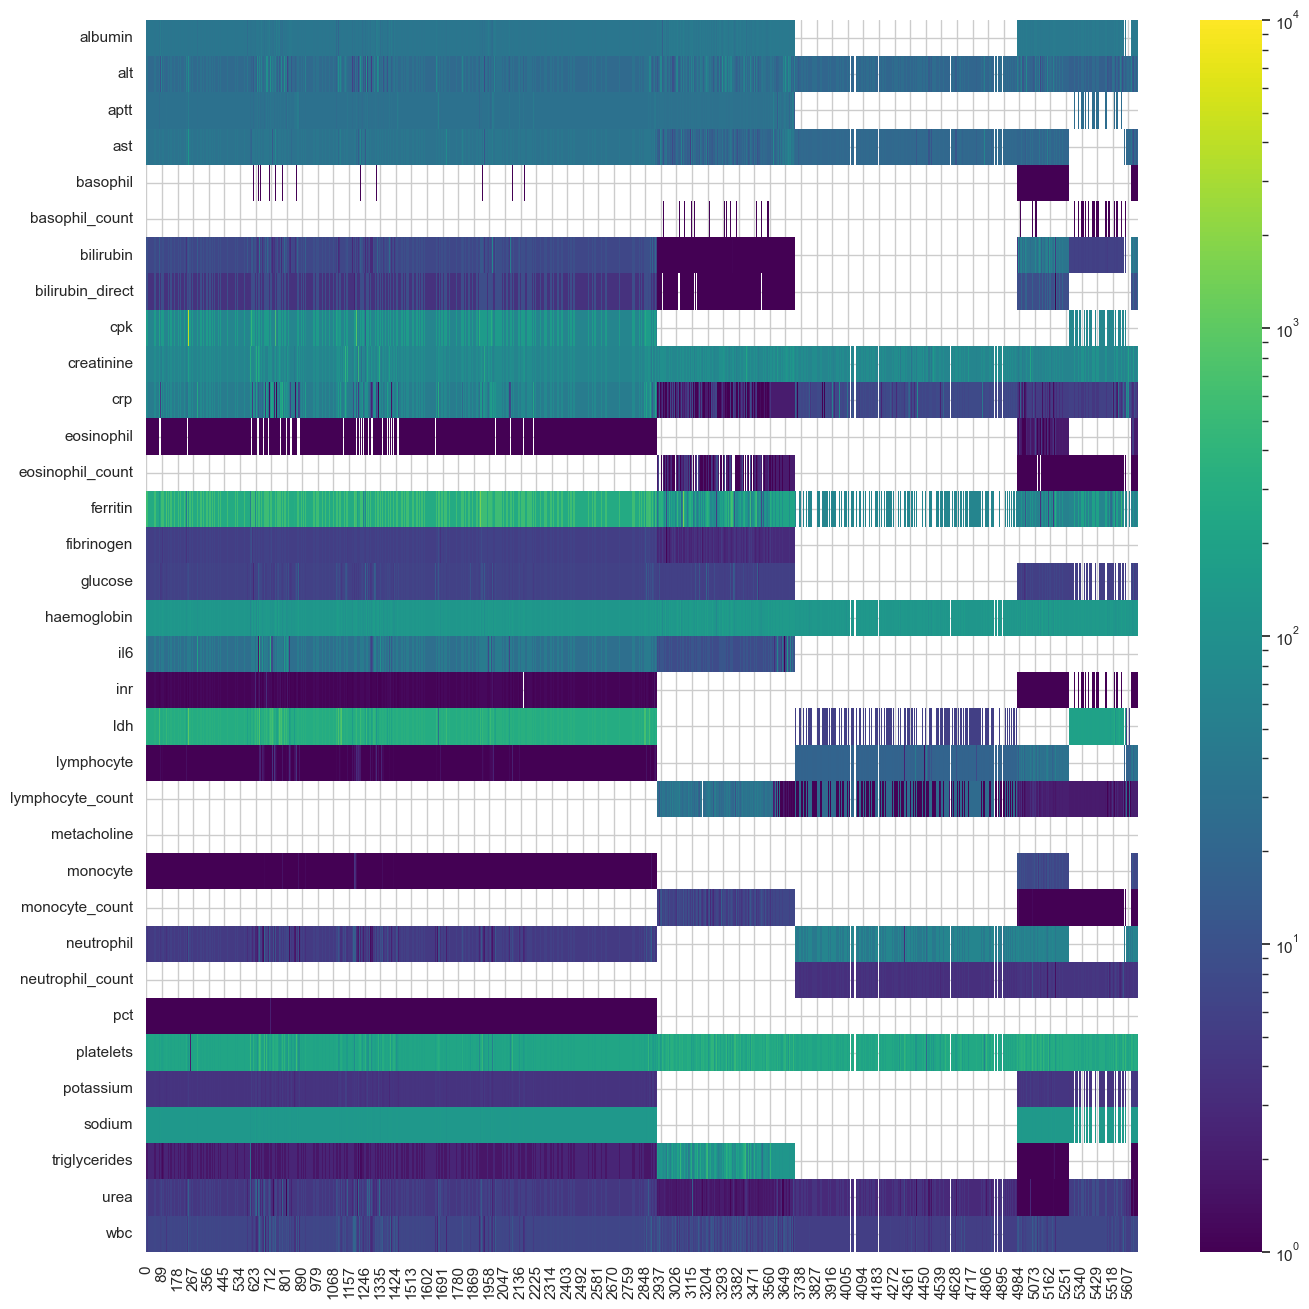

In [513]:
# heatmap
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [514]:
# are there records that are entirely nan?
t2[t2.isna().all(axis = 1)]
t2.dropna(how = 'all', inplace = True)

<Axes: >

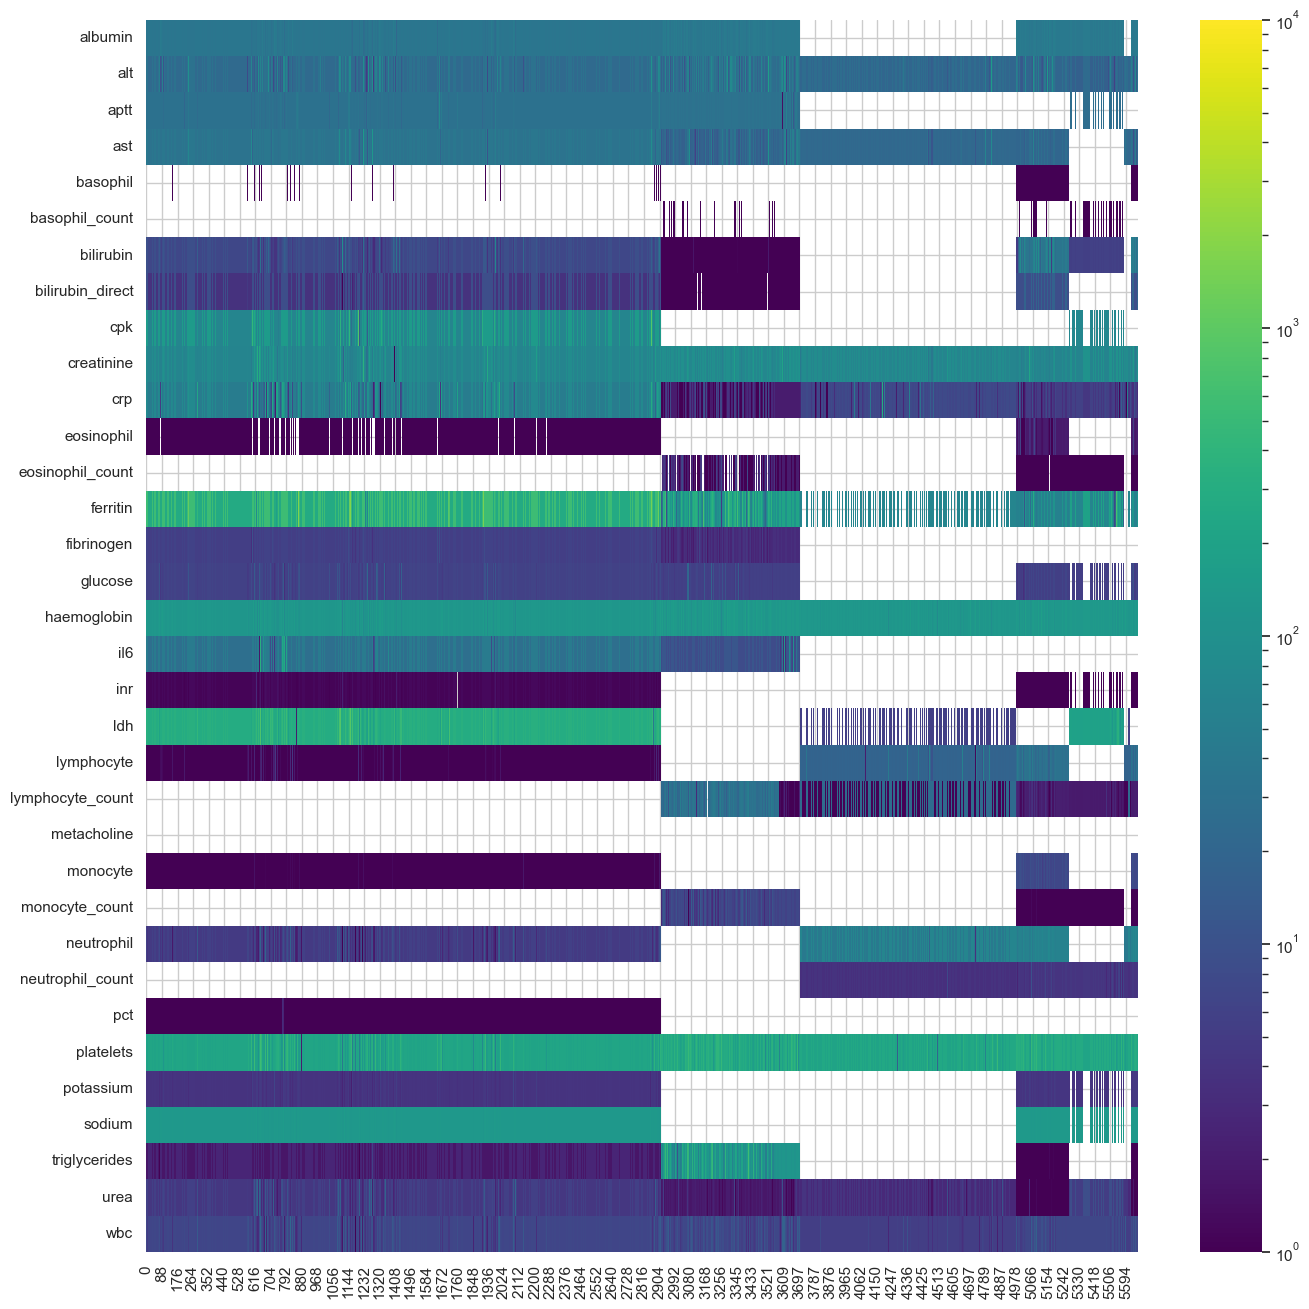

In [515]:
# heatmap
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

<Axes: >

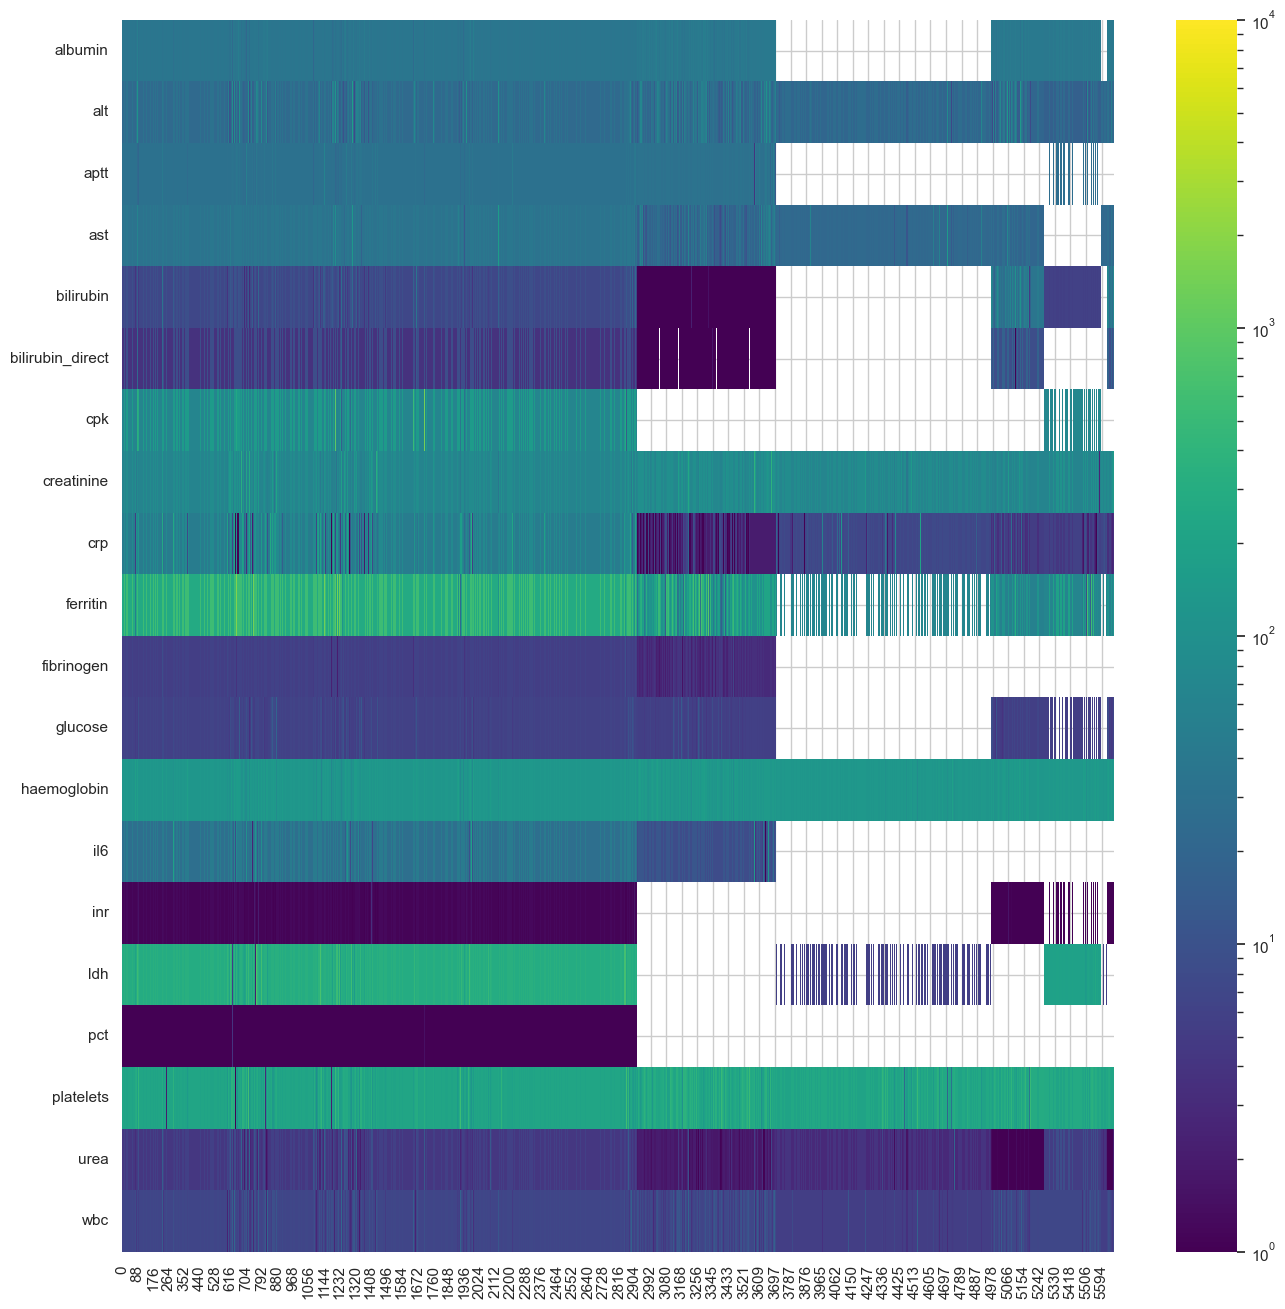

In [516]:
# drop some additional labs

CT2 = [col for col in CLINICAL_TESTS if not col.startswith(("eos", "meta", "m,ono", "neutro","potas","sodiu", "tri", "baso", "mono", "lymph"))]

t3 = t2[CT2]

# heatmap
fig, ax = plt.subplots(figsize=(16,16))

norm = mc.LogNorm(vmin=1, vmax=10_000)

sns.heatmap(t3.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [517]:
# which features have a complete set of data (no missing values)?

complete_features = t3.dropna(axis = 1, how = 'any') # type: ignore
complete_features

,alt,creatinine,crp,haemoglobin,platelets,urea,wbc
0,23.0,64.000,46.20,125.0,228.0,4.3000,6.60
1,32.0,85.000,77.60,138.0,210.0,5.8000,7.20
2,23.0,64.000,46.20,125.0,228.0,4.3000,6.60
3,23.0,64.000,46.20,125.0,228.0,4.3000,6.60
4,32.0,85.000,77.60,138.0,210.0,5.8000,7.20
...,...,...,...,...,...,...,...
5659,30.0,96.356,3.50,149.0,233.0,0.6660,6.90
5660,17.0,63.648,5.15,113.0,405.0,0.6105,13.88
5661,30.5,82.200,3.50,149.0,233.0,0.8000,6.90
5662,24.0,146.744,3.50,149.0,233.0,2.3310,6.90


In [518]:
# # sklearn median imputer

# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='median')

# clinical_test_features = b.copy()

# ctf_imputed = pd.DataFrame(imp.fit_transform(clinical_test_features), columns = clinical_test_features.columns)

# print(ctf_imputed.shape)


# clin_test_features = ctf_imputed
# # rename the columns with CLIN- prefix
# clin_test_features.columns = [f"CLIN-{col}" for col in clin_test_features.columns]


# # plot the heatmap
# fig, ax = plt.subplots(figsize=(16, 16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(clin_test_features.T, cbar=True, ax = ax, norm = norm)
# # set text size smaller
# plt.xticks(fontsize=8); plt.yticks(fontsize=8);
# plt.title("Clinical Tests - Imputed with Median")


# # find columns that are all zero
# all_zero = clin_test_features.columns[(clin_test_features == 0).all()]

# print(all_zero)

# # drop the all zero columns
# clin_test_features = clin_test_features.drop(columns = all_zero)

In [519]:
t1

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc,sex,dag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,44.0,30.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,96.356,...,NaN,NaN,NaN,4.6,142.0,0.4,0.6660,NaN,1.0,3
5660,38.0,17.0,NaN,13.0,0.2,NaN,NaN,NaN,NaN,63.648,...,NaN,NaN,405.0,4.5,138.0,NaN,0.6105,13.88,2.0,3
5661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,1.0,3
5662,43.0,24.0,NaN,24.0,NaN,NaN,70.72,NaN,NaN,146.744,...,NaN,NaN,NaN,4.9,138.0,NaN,2.3310,NaN,1.0,3


### Generate lab_features

In [130]:
# WIP: DO NOT IMPUTE

# no imputation
lab_features = labs_without_outliers
lab_features_ind = deepcopy(lab_features)

# no imputation, fixed LUS haemo values ## 2024-04-28: this is now DEPRECATED
# lab_features = t1.drop(["sex", "dag"], axis = 1)


# EXPT: use the reduced set of labs
# lab_features = complete_features

# rename the colummns by prefixing with LABS
lab_features.columns = [f"LABS-{col}" for col in lab_features.columns]

lab_features.shape

(5664, 34)

In [131]:
# ==============================================================================
# 2024-04-28: issue #3 - assume lab ordered for patients who need it for
# some reason or another
# ==============================================================================
# concept: either lab is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that lab was not indicated

# lab_features_ind = deepcopy(lab_features)
lab_features_ind = lab_features_ind.fillna(0)
lab_features_ind[lab_features_ind>0] = 1
lab_features_ind.columns = [f"LABS-IND-{col}" for col in lab_features_ind.columns]

In [132]:
lab_features.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LABS-albumin           1375 non-null   float64
 1   LABS-alt               1723 non-null   float64
 2   LABS-aptt              580 non-null    float64
 3   LABS-ast               1062 non-null   float64
 4   LABS-basophil          594 non-null    float64
 5   LABS-basophil_count    835 non-null    float64
 6   LABS-bilirubin         1453 non-null   float64
 7   LABS-bilirubin_direct  696 non-null    float64
 8   LABS-cpk               151 non-null    float64
 9   LABS-creatinine        1483 non-null   float64
 10  LABS-crp               1590 non-null   float64
 11  LABS-eosinophil        548 non-null    float64
 12  LABS-eosinophil_count  836 non-null    float64
 13  LABS-ferritin          898 non-null    float64
 14  LABS-fibrinogen        758 non-null    float64
 15  LABS

In [133]:
lab_features_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LABS-IND-albumin           5664 non-null   float64
 1   LABS-IND-alt               5664 non-null   float64
 2   LABS-IND-aptt              5664 non-null   float64
 3   LABS-IND-ast               5664 non-null   float64
 4   LABS-IND-basophil          5664 non-null   float64
 5   LABS-IND-basophil_count    5664 non-null   float64
 6   LABS-IND-bilirubin         5664 non-null   float64
 7   LABS-IND-bilirubin_direct  5664 non-null   float64
 8   LABS-IND-cpk               5664 non-null   float64
 9   LABS-IND-creatinine        5664 non-null   float64
 10  LABS-IND-crp               5664 non-null   float64
 11  LABS-IND-eosinophil        5664 non-null   float64
 12  LABS-IND-eosinophil_count  5664 non-null   float64
 13  LABS-IND-ferritin          5664 non-null   float

## CLINICAL DETAILS

### COMP - Complications

In [183]:
# read the list of symtpoms from the json file
import json
# with open("./OUTPUT/list-clin-details.json", "r") as f:
with open("./OUTPUT/list-complications-medcon.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
COMP = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
COMP = [col for col in COMP if not col.startswith(("phx", "phq"))]

# feature set for symptoms
comp_features = df[COMP]

# preprend CLIN- to the column names
comp_features.columns = [f"COMP-{col}" for col in comp_features.columns]

# find spaces in the data and replace with zero
comp_features = comp_features.replace(" ", 0)

#There is one patient with value of 4... replace all >1 to 1
comp_features[comp_features > 1] = 1

/tmp/ipykernel_275910/4028764151.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_features = comp_features.replace(" ", 0)


In [184]:
comp_features

,COMP-cardiovascular_complicatio___1,COMP-cardiovascular_complicatio___2,COMP-cardiovascular_complicatio___3,COMP-cardiovascular_complicatio___4,COMP-cardiac_arrest___1,COMP-cardiac_arrest___2,COMP-cardiac_arrest___3,COMP-cardiac_arrest___4,COMP-other_cardiac_arrhythmia___1,COMP-other_cardiac_arrhythmia___2,...,COMP-rhabdomyolysis___3,COMP-rhabdomyolysis___4,COMP-myositis___1,COMP-myositis___2,COMP-myositis___3,COMP-myositis___4,COMP-bacteriemia___1,COMP-bacteriemia___2,COMP-bacteriemia___3,COMP-bacteriemia___4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5662,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
# drop columns with dtype datetime64
comp_features = comp_features.select_dtypes(exclude = ['datetime64', 'object'])
comp_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 204 entries, COMP-cardiovascular_complicatio___1 to COMP-bacteriemia___4
dtypes: float64(204)
memory usage: 8.8 MB


Text(0.5, 1.0, 'COMP - Complications Status- missing values are light coloured')

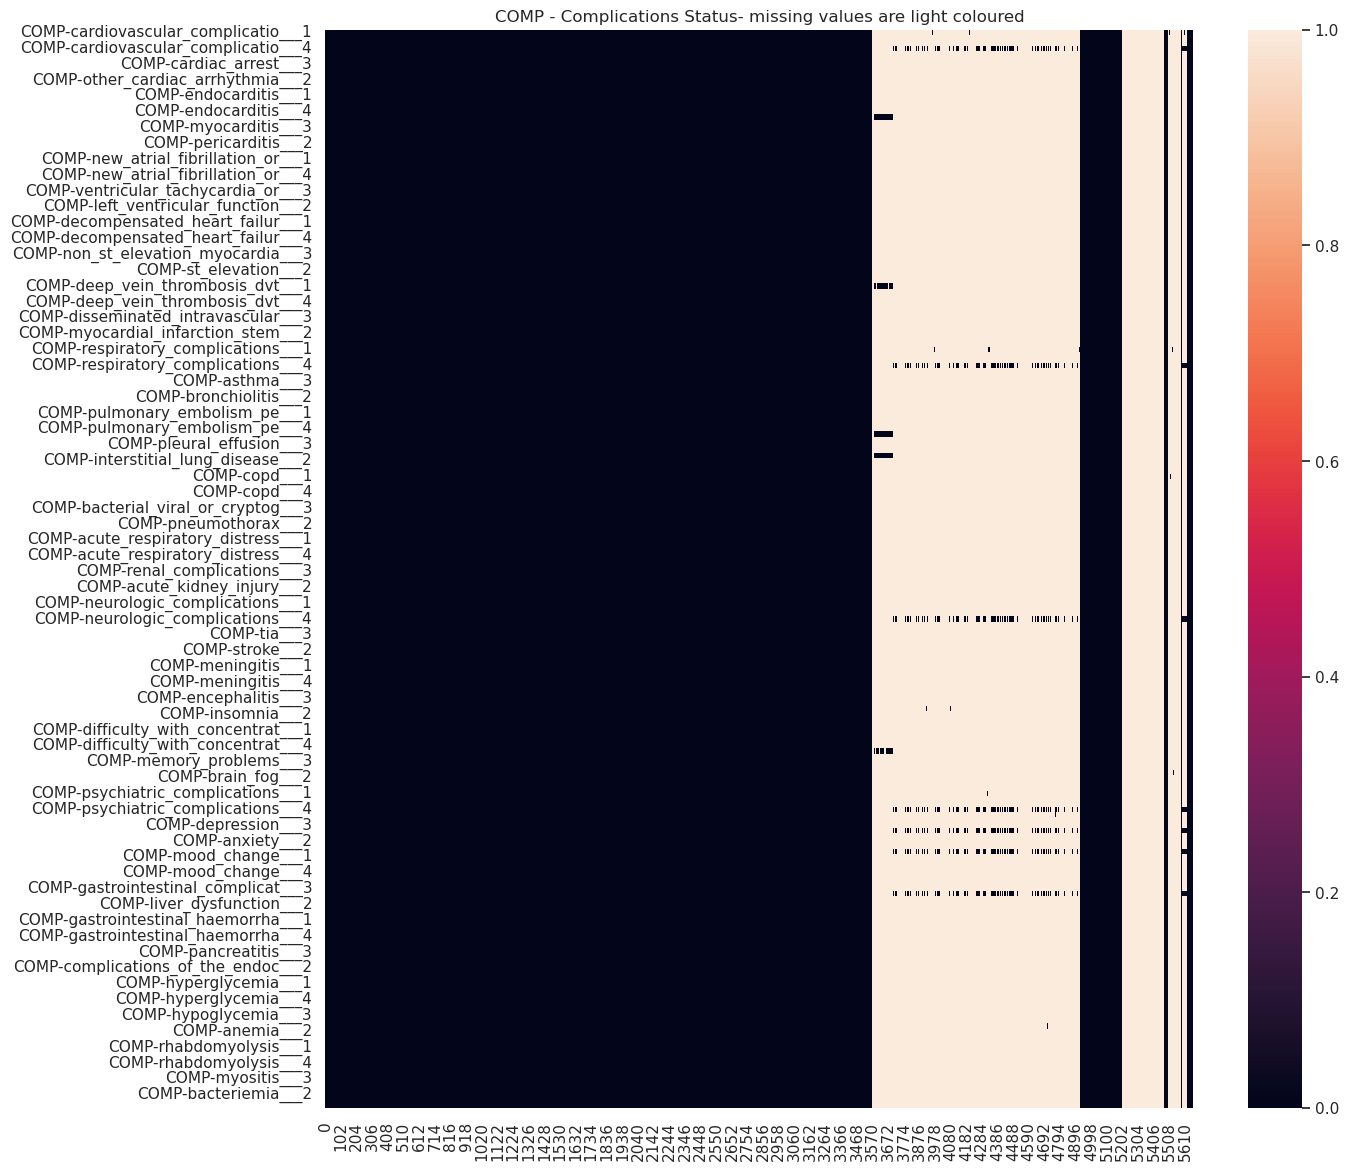

In [157]:

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(comp_features.isnull().T, cbar=True, ax = ax, )
plt.title("COMP - Complications Status- missing values are light coloured")

Percent Missing of Comp By Site


Text(0.5, 1.0, 'Percent of Comp Missing By Site')

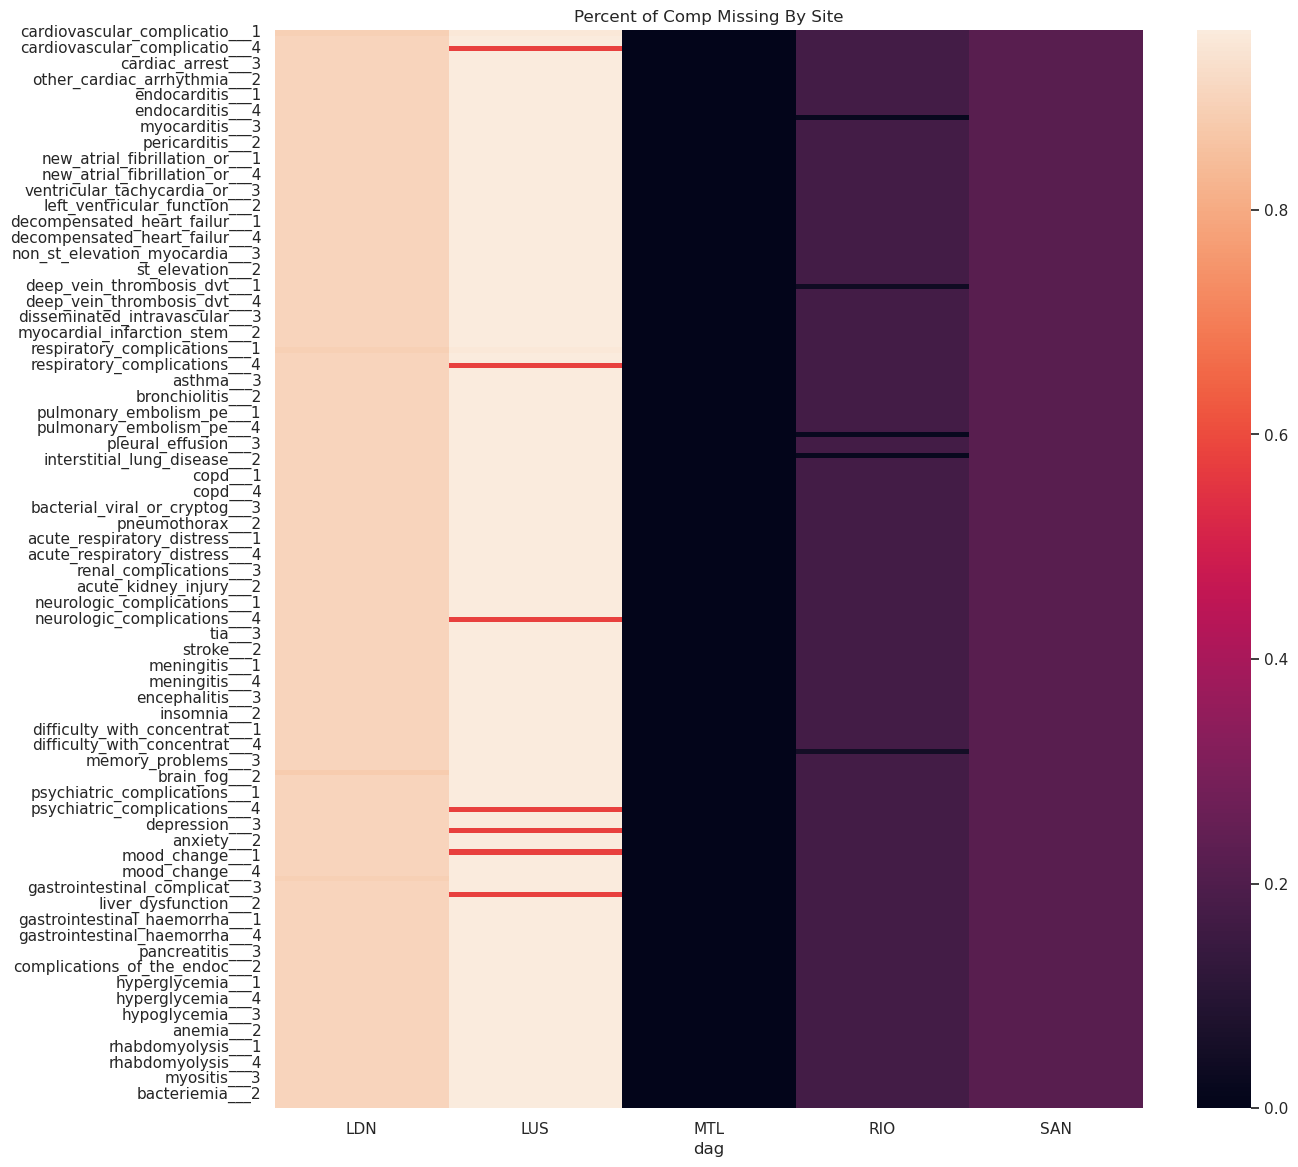

In [190]:
print('Percent Missing of Comp By Site')
fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(
    (
        df.groupby("dag")[COMP]
        .apply(lambda x: x.isnull().sum())
        .rename(index=site_name_dict)
        .T
        / df.dag.value_counts().rename(index=site_name_dict)
    ).round(2), ax=ax,
)
plt.title("Percent of Comp Missing By Site")

In [544]:
# # these features are not very informative - consider dropping them
# comp_features = comp_features.drop(columns = cd_features.filter(like = "test_type").columns)

# # height in metres and centimetres is redundant
# # drop the height in cm
# # comp_features = comp_features.drop(columns = "CD-height_cm")

# comp_features.info()

In [152]:
# sort alphabetically
comp_features = comp_features.reindex(sorted(comp_features.columns), axis=1)

In [153]:
#==============================================================================
# 2024-04-28
#==============================================================================

# fill the missing values with zero, per email discussion 2024-04-28
# closes #2
comp_features = comp_features.fillna(0)


In [557]:

# fig, ax = plt.subplots(figsize=(44,44))

# sns.heatmap(comp_features.isnull().T, cbar=True, ax = ax, )
# plt.title("COMP Status - missing values are light coloured")
# # missing values by site
# print("Missing COMP values by site:")

# comp_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

### CD - Clinical Details

In [ ]:
# read the list of symtpoms from the json file
import json
# with open("./OUTPUT/list-clin-details.json", "r") as f:
with open("./OUTPUT/list-complications-medcon.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
COMP = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
COMP = [col for col in COMP if not col.startswith(("phx", "phq"))]

# feature set for symptoms
comp_features = df[COMP]

# preprend CLIN- to the column names
comp_features.columns = [f"COMP-{col}" for col in comp_features.columns]

# find spaces in the data and replace with zero
comp_features = comp_features.replace(" ", 0)

#There is one patient with value of 4... replace all >1 to 1
comp_features[comp_features > 1] = 1

/tmp/ipykernel_275910/4028764151.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_features = comp_features.replace(" ", 0)


## VACCINES

In [531]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

# use only vaccine status
# 2024-04-28: confirmed only using VAX status
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(5664, 1)


In [532]:
#==============================================================================
# 2024-04-28: deprecate this material below
#==============================================================================

# vvv = pd.concat([df[VAX], df['dag']], axis = 1)
# vl = vvv.groupby('dag').sum().T.sum()
# vl
# pd.concat([vax_features, df['dag']], axis = 1).groupby('dag').sum().T.sum()
# # how many rows with dag = 5?
# vvv.query('dag == 5').shape
# # get a subset of vvv for dag = 5
# vl = vvv.query('dag == 5').head()

# # how many nans per column?
# vl.isnull().sum()

# vl
# # count non-zero values per dag
# vvv.groupby(df['dag']).apply(lambda x: x.astype(bool).sum(axis=0)).rename(index = site_name_dict)

Text(0.5, 1.0, 'Vaccination Status - missing values are light coloured')

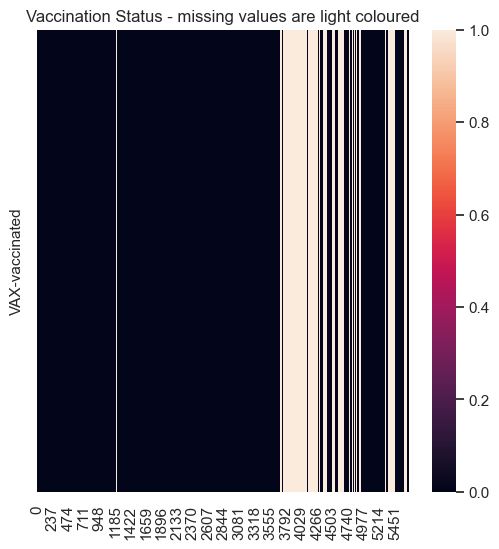

In [533]:
fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
plt.title("Vaccination Status - missing values are light coloured")

In [534]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing VAX values by site:


dag,LDN,MTL,SAN,RIO,LUS
VAX-vaccinated,158,41,7,0,931


In [535]:
# # how many nulls per site?
# print("Missing VACCINE values by site:")
# df.groupby('dag')[VAX + VAX_STATUS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


### CONCLUSION:
# - use only the vaccine status (binary)

# SAVE FEATURES TO FILE

In [558]:
# demographic_features
# medication_features
# hx_features_all
# survey_features
# symptom_features
# clinical_features
# vax_features

# concatenate all of the features
features = pd.concat([
                        demographic_features, 
                        medication_features, 
                        symptom_features, 
                        vax_features,
                        hx_features_all, 
                        imaging_features,
                        lab_features, 
                        substance_features, #selected by MP for now
                        # WIP: 
                        comp_features,
                        # cd_features,
                        # none
                        # NOT SELECTED:
                        # survey_features,    # not selected
                      ], axis = 1)

features["LC_STATUS"] = df["LC_STATUS"]

In [559]:
features.shape

(5664, 394)

In [560]:
# count the nulls per site
print("Missing values by site:")

features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing values by site:


/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_75163/4098030052.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()


dag
LDN    10487
MTL    85590
SAN     7057
RIO    15649
LUS    46633
dtype: int64

Text(0.5, 1.0, 'Missing values - light coloured cells are missing')

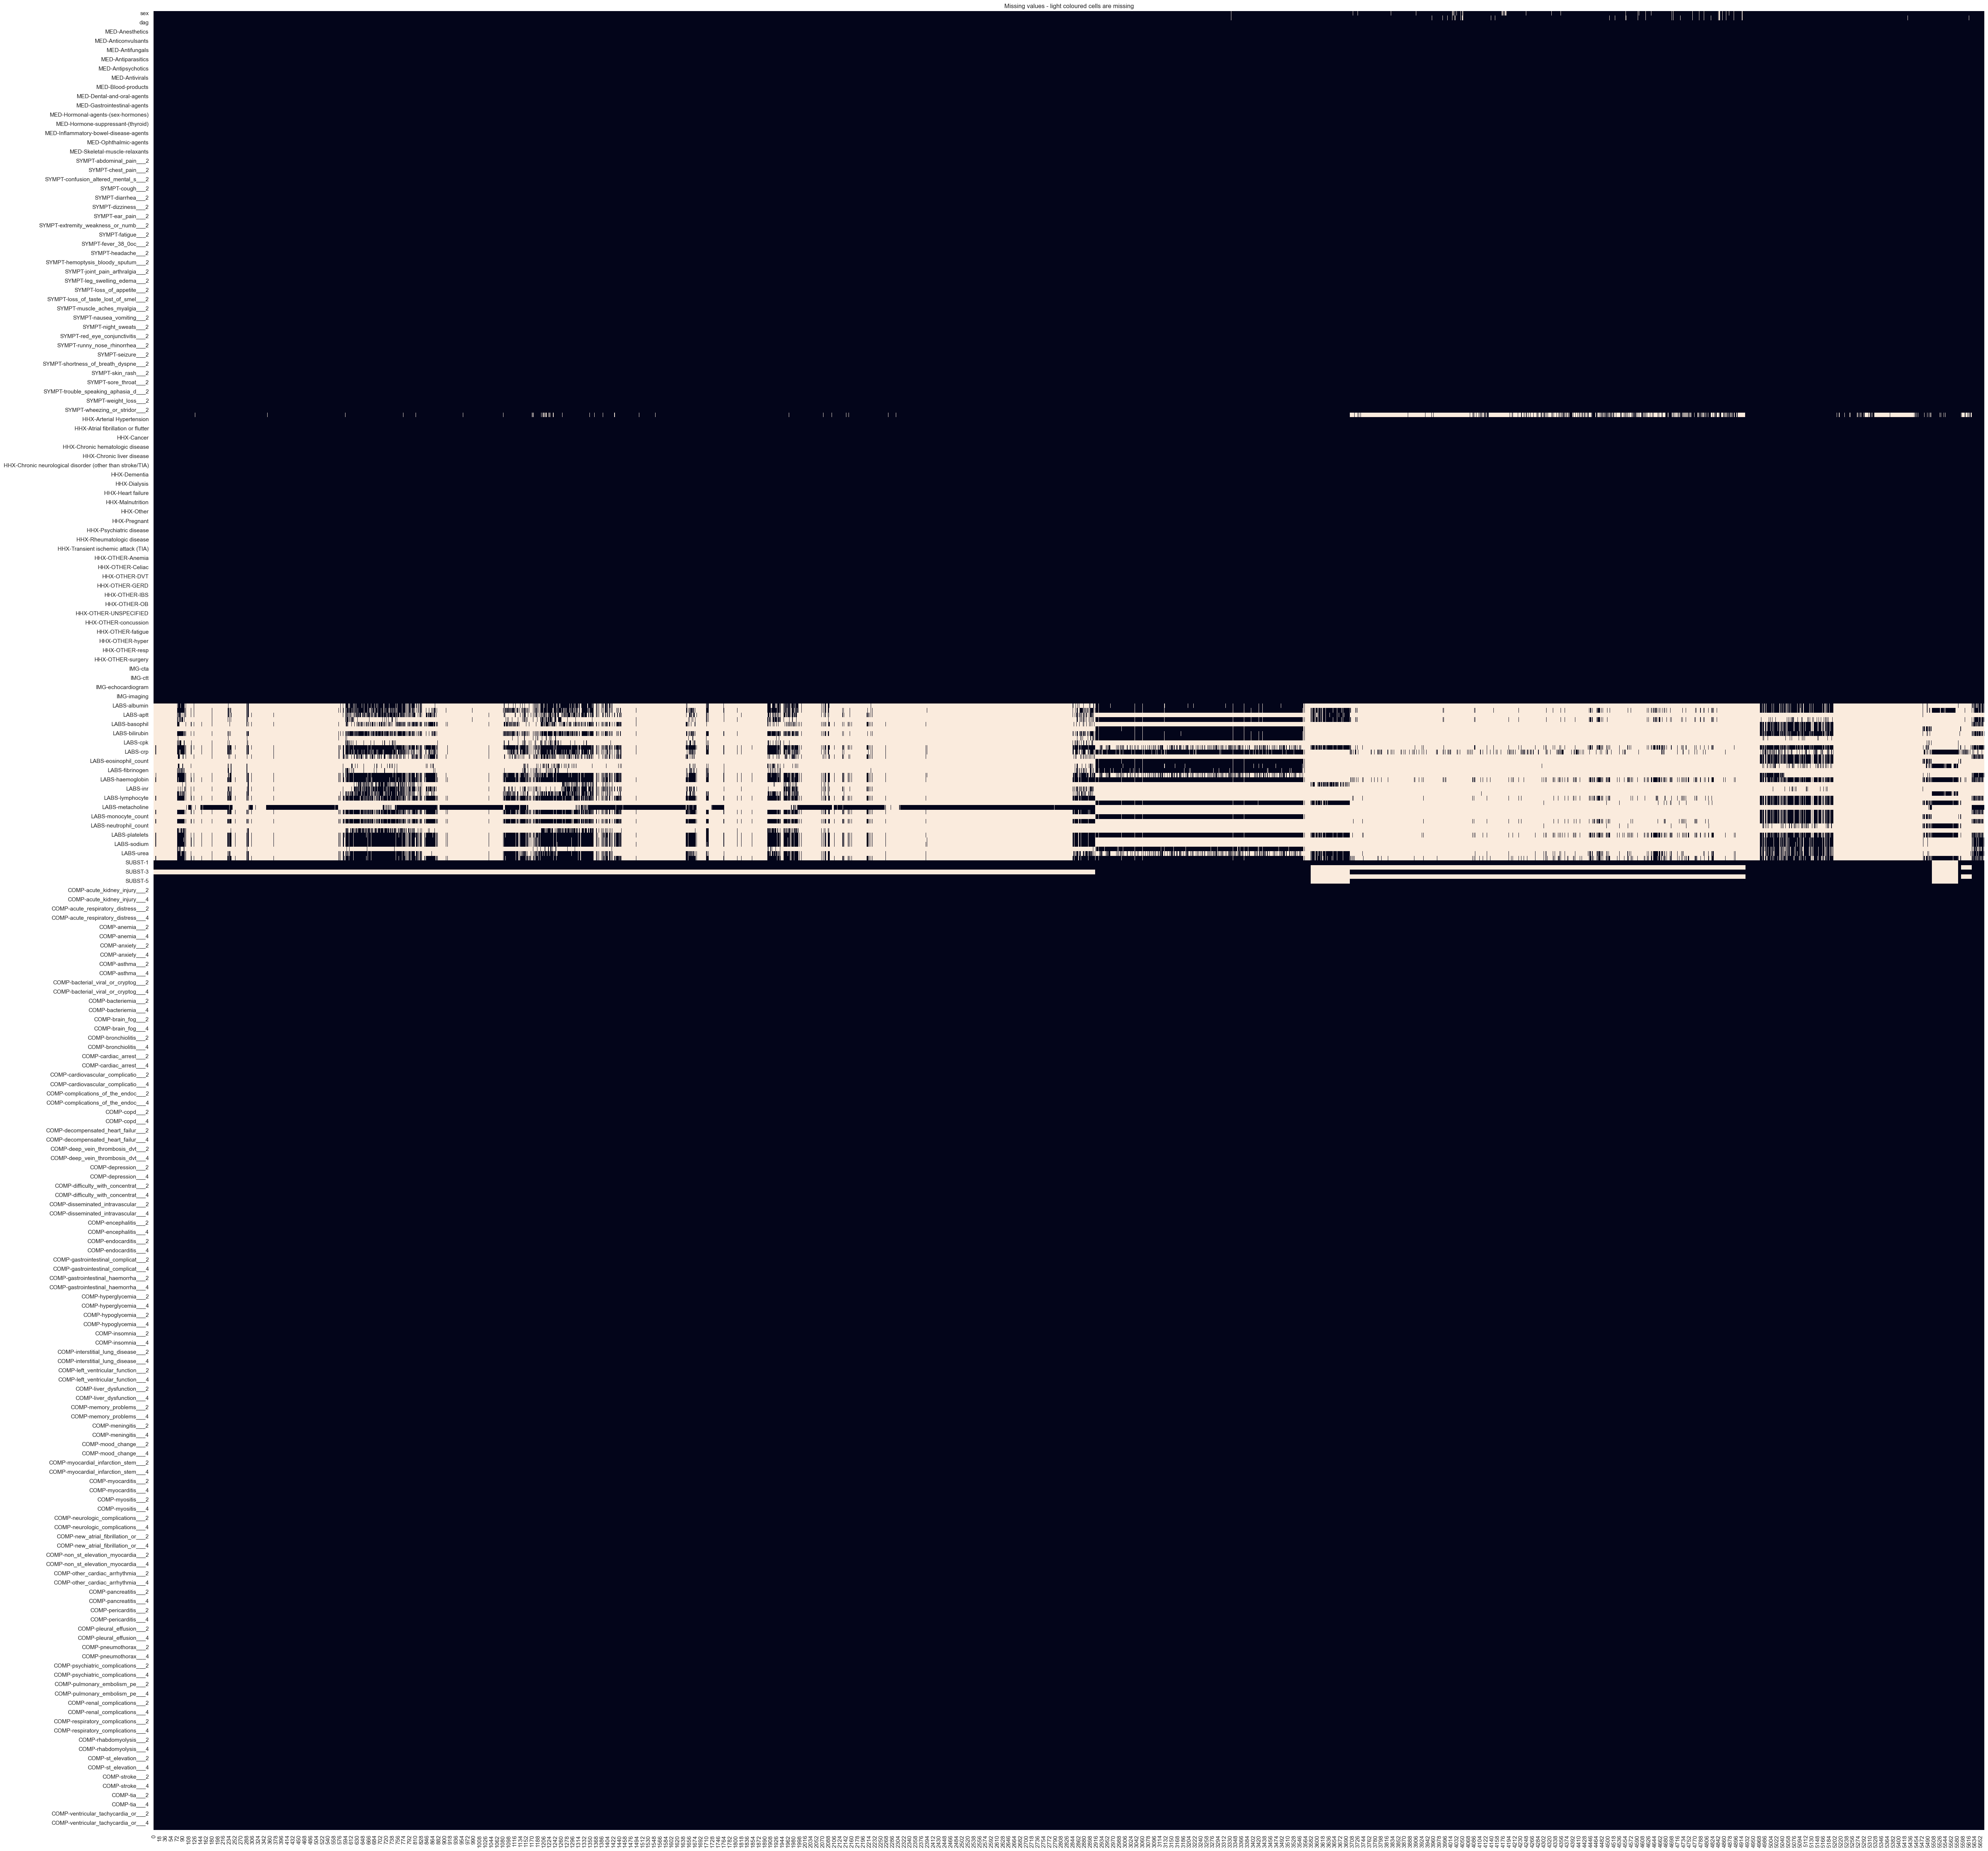

In [562]:
fig, ax = plt.subplots(figsize=(64,64))

sns.heatmap(features.isnull().T, cbar=False, ax = ax)

plt.title("Missing values - light coloured cells are missing")

In [563]:
features.columns = features.columns.str.strip()  # ensure columns are clean

In [564]:
features = features.rename(columns={'dag':'SITE'}) #rename dag to SITES

In [565]:

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# get today's data as a string
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")


# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features, preserve_index=True)
ds.save_to_disk(output_path / f"{today}-features.arrow")

Saving the dataset (0/1 shards):   0%|          | 0/5664 [00:00<?, ? examples/s]

In [566]:
features.columns

Index(['sex', 'age', 'SITE', 'MED-Analgesics', 'MED-Anesthetics',
       'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants',
       'MED-Antifungals', 'MED-Antimigraine-agents',
       ...
       'COMP-stroke___4', 'COMP-tia___1', 'COMP-tia___2', 'COMP-tia___3',
       'COMP-tia___4', 'COMP-ventricular_tachycardia_or___1',
       'COMP-ventricular_tachycardia_or___2',
       'COMP-ventricular_tachycardia_or___3',
       'COMP-ventricular_tachycardia_or___4', 'LC_STATUS'],
      dtype='object', length=394)